### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [17]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10Hz, sampling rate 4096 Hz and we want 20s of duration

In [18]:
# Adding the known constants - changed min_freq to 12 Hz as presented in the next problems
sample_rate = 4096
min_freq = 12
dur=20

# Finding delta f, t, total length and the psd length (flen)
dlt_f=1/dur
dlt_t=1/sample_rate
length=int(dur/dlt_t)
flen=int(sample_rate / 2 / dlt_f) + 1

#The equations and the code were taken from https://pycbc.org/pycbc/latest/html/psd.html: Estimating the PSD of a time series

data = pycbc.psd.from_txt('/content/aligo_O4high.txt', flen, dlt_f,  min_freq)

noise_data = pycbc.noise.gaussian.noise_from_psd(length, dlt_t, psd=data)

print(data,'\n')
print(len(data),'\n')
print(noise_data)


[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.94481255e-47
 6.94502931e-47 6.94524606e-47] 

40961 

[7.30421116e-22 6.09186418e-22 5.11130734e-22 ... 3.47520483e-21
 3.96822651e-21 3.90020712e-21]


As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

In [19]:
# Making the signal
hp,hc=pycbc.waveform.waveform.get_td_waveform(template = None, mass1 = 50, mass2 = 50, distance = 2000, delta_t = dlt_t, approximant="IMRPhenomD", f_lower = min_freq)

# Testing the structure of tha data
print(hp,'\n',hc)
print(len(hp),len(hc))

print(hp.sample_times,noise_data.sample_times)

[8.21392108e-28 8.65229202e-28 9.11163212e-28 ... 7.03847340e-28
 7.41522943e-28 7.80285476e-28] 
 [-2.56780203e-27 -2.56497317e-27 -2.55970502e-27 ... -2.57691478e-27
 -2.57241742e-27 -2.56974234e-27]
65536 65536
[-11.         -10.99975586 -10.99951172 ...   4.99926758   4.99951172
   4.99975586] [0.00000000e+00 2.44140625e-04 4.88281250e-04 ... 1.99992676e+01
 1.99995117e+01 1.99997559e+01]


How does the waveform amplitude compare to the detector noise?

As it can be seen in from the graphs below, it is impossible to get any information out of the detector noise. This is because the detector signal is weaker by 2 orders of magnitude compared with the noise.


16384


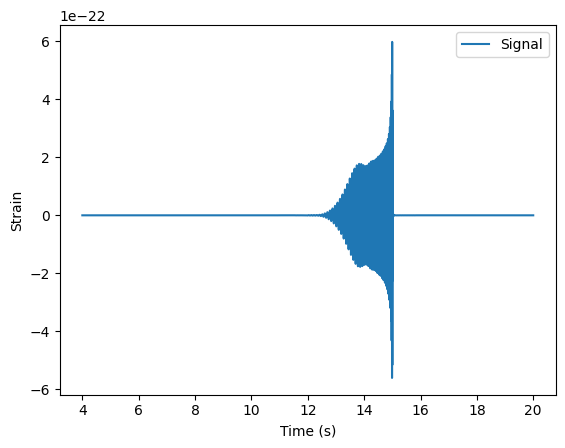

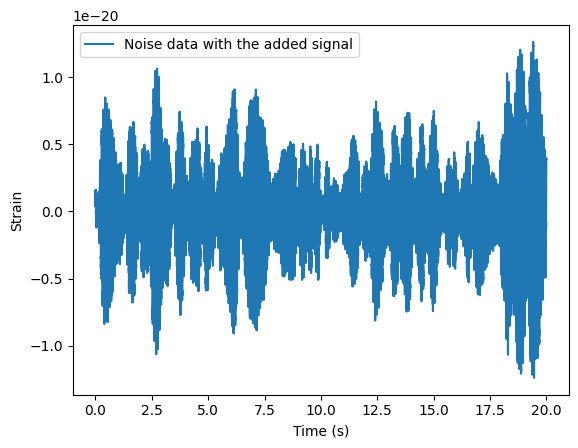

65536 81920 81920


In [20]:

#print(hp.sample_times,noise_data.sample_times)

#we change the start time for hp and hc so to add them to the data
hp.start_time=4
hc.start_time=4

dt = noise_data.copy()

#print(len(dt),len(hp))

#we add hp to the data
start_index = length - len(hp)
print(start_index)
dt[start_index:start_index+len(hp)] += hp


#Everything is plotted
plt.plot(hp.sample_times, hp, label="Signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

plt.plot(dt.sample_times, dt, label="Noise data with the added signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()


print(len(hp),len(noise_data),length)


How does the waveform change because of this projection?

As it can be seen in the graph below the projected form has changed in size, shrinking.

0.06243712081948721


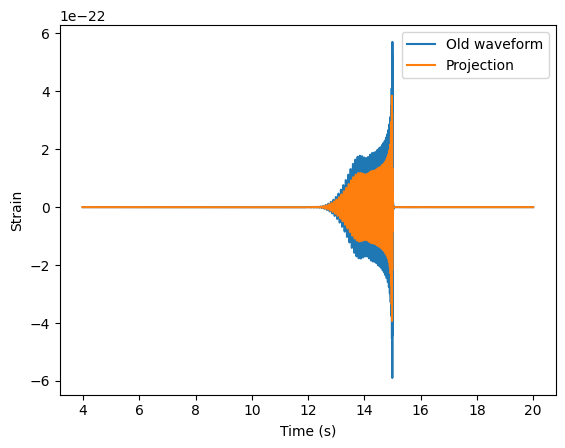

In [21]:

detector = Detector("L1")

#We get random numbers
ra = random.uniform(0, 2 * np.pi)
dec = random.uniform(-np.pi * 2, np.pi * 2)
polar = random.uniform(0, 2 * np.pi)


#the given function is used
prj = detector.project_wave(hp, hc, ra = ra, dec = dec, polarization = polar)

print(prj.delta_f)
#the comparison between hc and f is done
plt.plot(hc.sample_times, hc, label="Old waveform")
plt.plot(prj.sample_times, prj, label="Projection")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()


**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?

_This part was partially done with the start at 4 sec in the last exercise, a similar procedure will be used here_

0.05


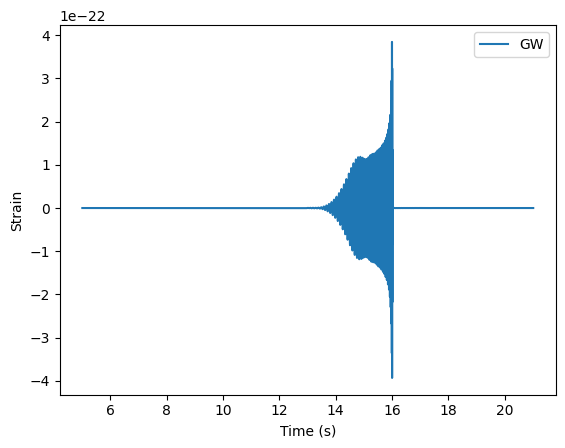

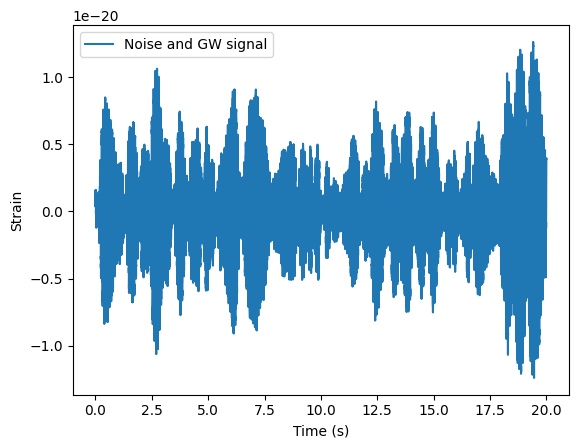

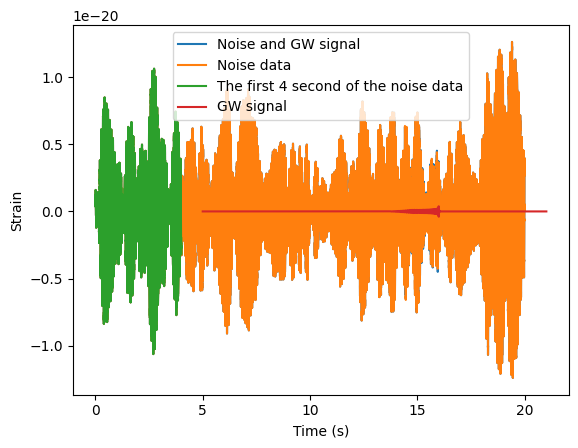

In [22]:
#print(hp.sample_times,noise_data.sample_times)

# We change the start time of prj so to add them to the data
noise_data.start_time=0
prj.start_time=noise_data.start_time + 5

dt = noise_data.copy() # Make copy to conserve the original noise data

#print(len(dt),len(hp))

# We add projection to the noise data

#print(noise_data.start_time)

start = int(5 / dlt_t)

dt[start : start + len(prj[ : len(dt) - start])] += prj[ : len(dt) - start]

# The fist 4 sec data str is made
f4s = noise_data[:int(4/dlt_t)]

print(dt.delta_f)

#GW signal
plt.plot(prj.sample_times, prj, label="GW")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

#Noise + GW signal
plt.plot(dt.sample_times, dt, label="Noise and GW signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

#The full plot with all that data
plt.plot(dt.sample_times, dt, label="Noise and GW signal")
plt.plot(noise_data.sample_times, noise_data, label="Noise data")
plt.plot(f4s.sample_times, f4s, label="The first 4 second of the noise data")
plt.plot(prj.sample_times, prj, label="GW signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()



**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


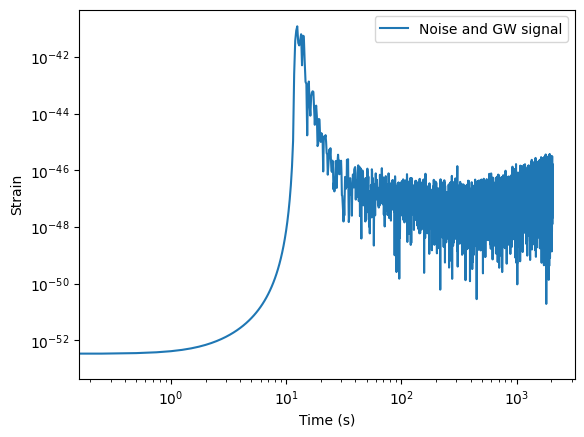

The delta f of the estimated PSD is: 0.25
The delta f of the data we want to whiten: 0.05


In [23]:
# Make the welch data structure
welch = pycbc.psd.estimate.welch(f4s, seg_len = sample_rate * 4, seg_stride = sample_rate * 2, window='hann', avg_method='median', num_segments=None, require_exact_data_fit=False)

#Noise + GW signal
plt.loglog(welch.sample_frequencies, welch, label="Noise and GW signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()


# Show the delta f
print('The delta f of the estimated PSD is:', welch.delta_f)
print('The delta f of the data we want to whiten:', dt.delta_f)


Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

In [24]:
# Interpolate and truncate the welch data
it_welch = pycbc.psd.estimate.interpolate(welch, dlt_f, length=None)
trc_it_welch = pycbc.psd.estimate.inverse_spectrum_truncation(it_welch, max_filter_len = 4 * sample_rate, low_frequency_cutoff=12, trunc_method=None)


# Test teh new data structures
print(welch)
print(it_welch)
print(trc_it_welch,'\n')
print(len(dt),len(welch),len(it_welch),len(trc_it_welch),'\n')

print(dt.delta_f,trc_it_welch.delta_f,)


[1.68733129e-53 3.42227651e-53 3.56656878e-53 ... 1.68176728e-46
 1.01838409e-46 2.39625538e-47]
[1.68733129e-53 2.03432033e-53 2.38130938e-53 ... 5.51128958e-47
 3.95377248e-47 2.39625538e-47]
[5.32706222e-44 7.58165759e-44 2.39430128e-43 ... 7.68819789e-47
 7.71409121e-47 7.73582941e-47] 

81920 8193 40961 40961 

0.05 0.05


Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

As the GW signal for my data peeks at time point 16 I changed the border cutting to 12 and 18.

Yes, now the GW signal is visible!

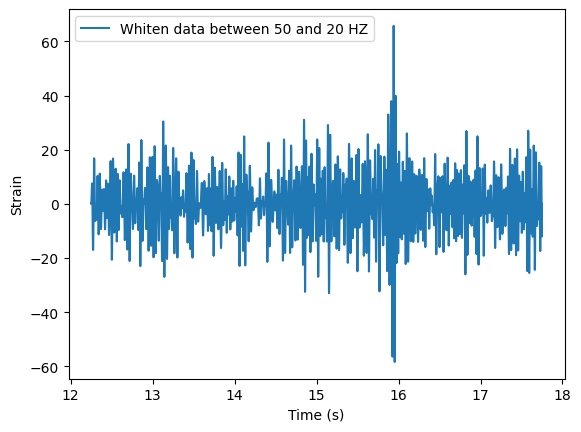

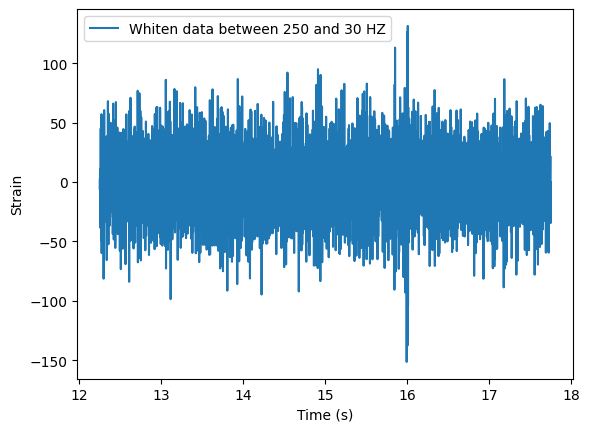

In [25]:
#As the psd is presented in frequency we need to change our data from time series to frequency series
f_dt = dt.to_frequencyseries()

#The desired eq
wh_dt = f_dt / np.sqrt(trc_it_welch)

#Going back to time series
wh_dt = wh_dt.to_timeseries()

#Cutting the borders
wh_dt = wh_dt[int(12/wh_dt.delta_t):int(18/wh_dt.delta_t)]

#Bandoassing the data (my ideas)
wh_low_data = wh_dt.lowpass_fir(frequency=50, order=512)
wh_all_data = wh_low_data.highpass_fir(frequency=20, order=512)


#My own play with the data
plt.plot(wh_all_data.sample_times, wh_all_data, label="Whiten data between 50 and 20 HZ")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

#Bandoassing the data as presented in the lab
wh_low_data_last = wh_dt.lowpass_fir(frequency=250, order=512)
wh_all_data_last =  wh_low_data_last.highpass_fir(frequency=30, order=512)

#The data plotting
plt.plot(wh_all_data_last.sample_times, wh_all_data_last, label="Whiten data between 250 and 30 HZ")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.show()

So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}

where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

Peak time (s): 17.728271484375
Max |SNR|: 18.941841269380728
Trigger generated? (|SNR|>5): True


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


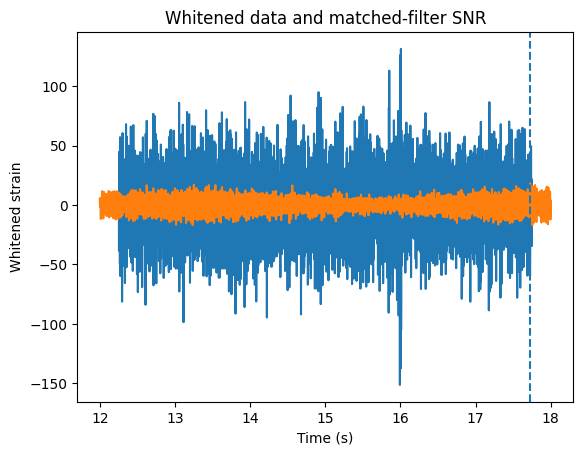

In [26]:
# We will take hp as the template and processed it
template = prj.copy()
template.resize(len(dt))  # Such to work on the data

template = template.to_frequencyseries() # Change in frequency
template = template.cyclic_time_shift(template.start_time)

# Make the snr
snr = pycbc.filter.matchedfilter.matched_filter(template, dt, psd = trc_it_welch, low_frequency_cutoff = 12)

# Crop it at the
snr = snr.crop(12, 2)

# Printing the information
abs_snr = np.abs(snr)
imax = abs_snr.numpy().argmax()
t_peak = snr.sample_times[imax]

print("Peak time (s):", float(t_peak))
print("Max |SNR|:", float(abs_snr[imax]))
print("Trigger generated? (|SNR|>5):", bool(abs_snr[imax] > 5))

# Plotting the graph
plt.plot(wh_all_data_last.sample_times, wh_all_data_last)
plt.plot(snr.sample_times, snr)
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.axvline(t_peak, linestyle = "--")
plt.title("Whitened data and matched-filter SNR")
plt.show()


Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.